In [1]:
%%sh
pwd

/home/lausena/developer/repos/spacecraft-pose-pose-estimation-runtime/juptyer-notebooks


In [45]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

In [4]:
root = '/home/lausena/developer/repos/spacecraft-pose-pose-estimation-runtime/'

In [6]:
img1path = os.path.join(root, 'data/images/01f0f7459b/000.png')
img2path = os.path.join(root, 'data/images/01f0f7459b/001.png')

img1 = cv.imread(img1path, cv.IMREAD_GRAYSCALE)
img2 = cv.imread(img2path, cv.IMREAD_GRAYSCALE)

In [7]:
sift = cv.SIFT_create()

In [8]:
keypoints1, descriptor1 = sift.detectAndCompute(img1, None)
keypoints2, descriptor2 = sift.detectAndCompute(img2, None)

In [9]:
FLANN_INDEX_KDTREE = 1
indexParams = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
searchParams = dict(checks=50)
flann = cv.FlannBasedMatcher(indexParams, searchParams)
nNeighbors = 2

In [10]:
matches = flann.knnMatch(descriptor1, descriptor2, k=nNeighbors)

In [15]:
goodMatches = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        goodMatches.append(m)

minGoodMatches = 10

In [16]:
len(goodMatches)

12

In [121]:
if len(goodMatches) > minGoodMatches:
    source_points = np.float32([keypoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)
    destination_points = np.float32([keypoints2[m.queryIdx].pt for m in goodMatches]).reshape(-1,1,2)
    errorThreshold = 5
    M, mask = cv.findHomography(source_points, destination_points, cv.RANSAC, errorThreshold)
    matches_mask = mask.ravel().tolist()
    h,w = img1.shape
    img_border = np.float32([[0,0], [0, h-1], [w-1, h-1], [w-1,0]]).reshape(-1,1,2)
    warped_img_border = cv.perspectiveTransform(img_border, M)
    img2_poly = cv.polylines(img2, [np.int32(warped_img_border)], True, 255, 3, cv.LINE_AA)
else:
    print('Not enough good matches')

In [129]:
attributes = dir(goodMatches[0])
public_attributes = [attr for attr in attributes if not attr.startswith('_')]
public_attributes

['distance', 'imgIdx', 'queryIdx', 'trainIdx']

In [119]:
green = (0, 255, 0)
drawParams = dict(matchColor=green, singlePointColor=None, matchesMask=matches_mask, flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
imgMatch = cv.drawMatches(img1, keypoints1, img2_poly, keypoints2, goodMatches, None, **drawParams)

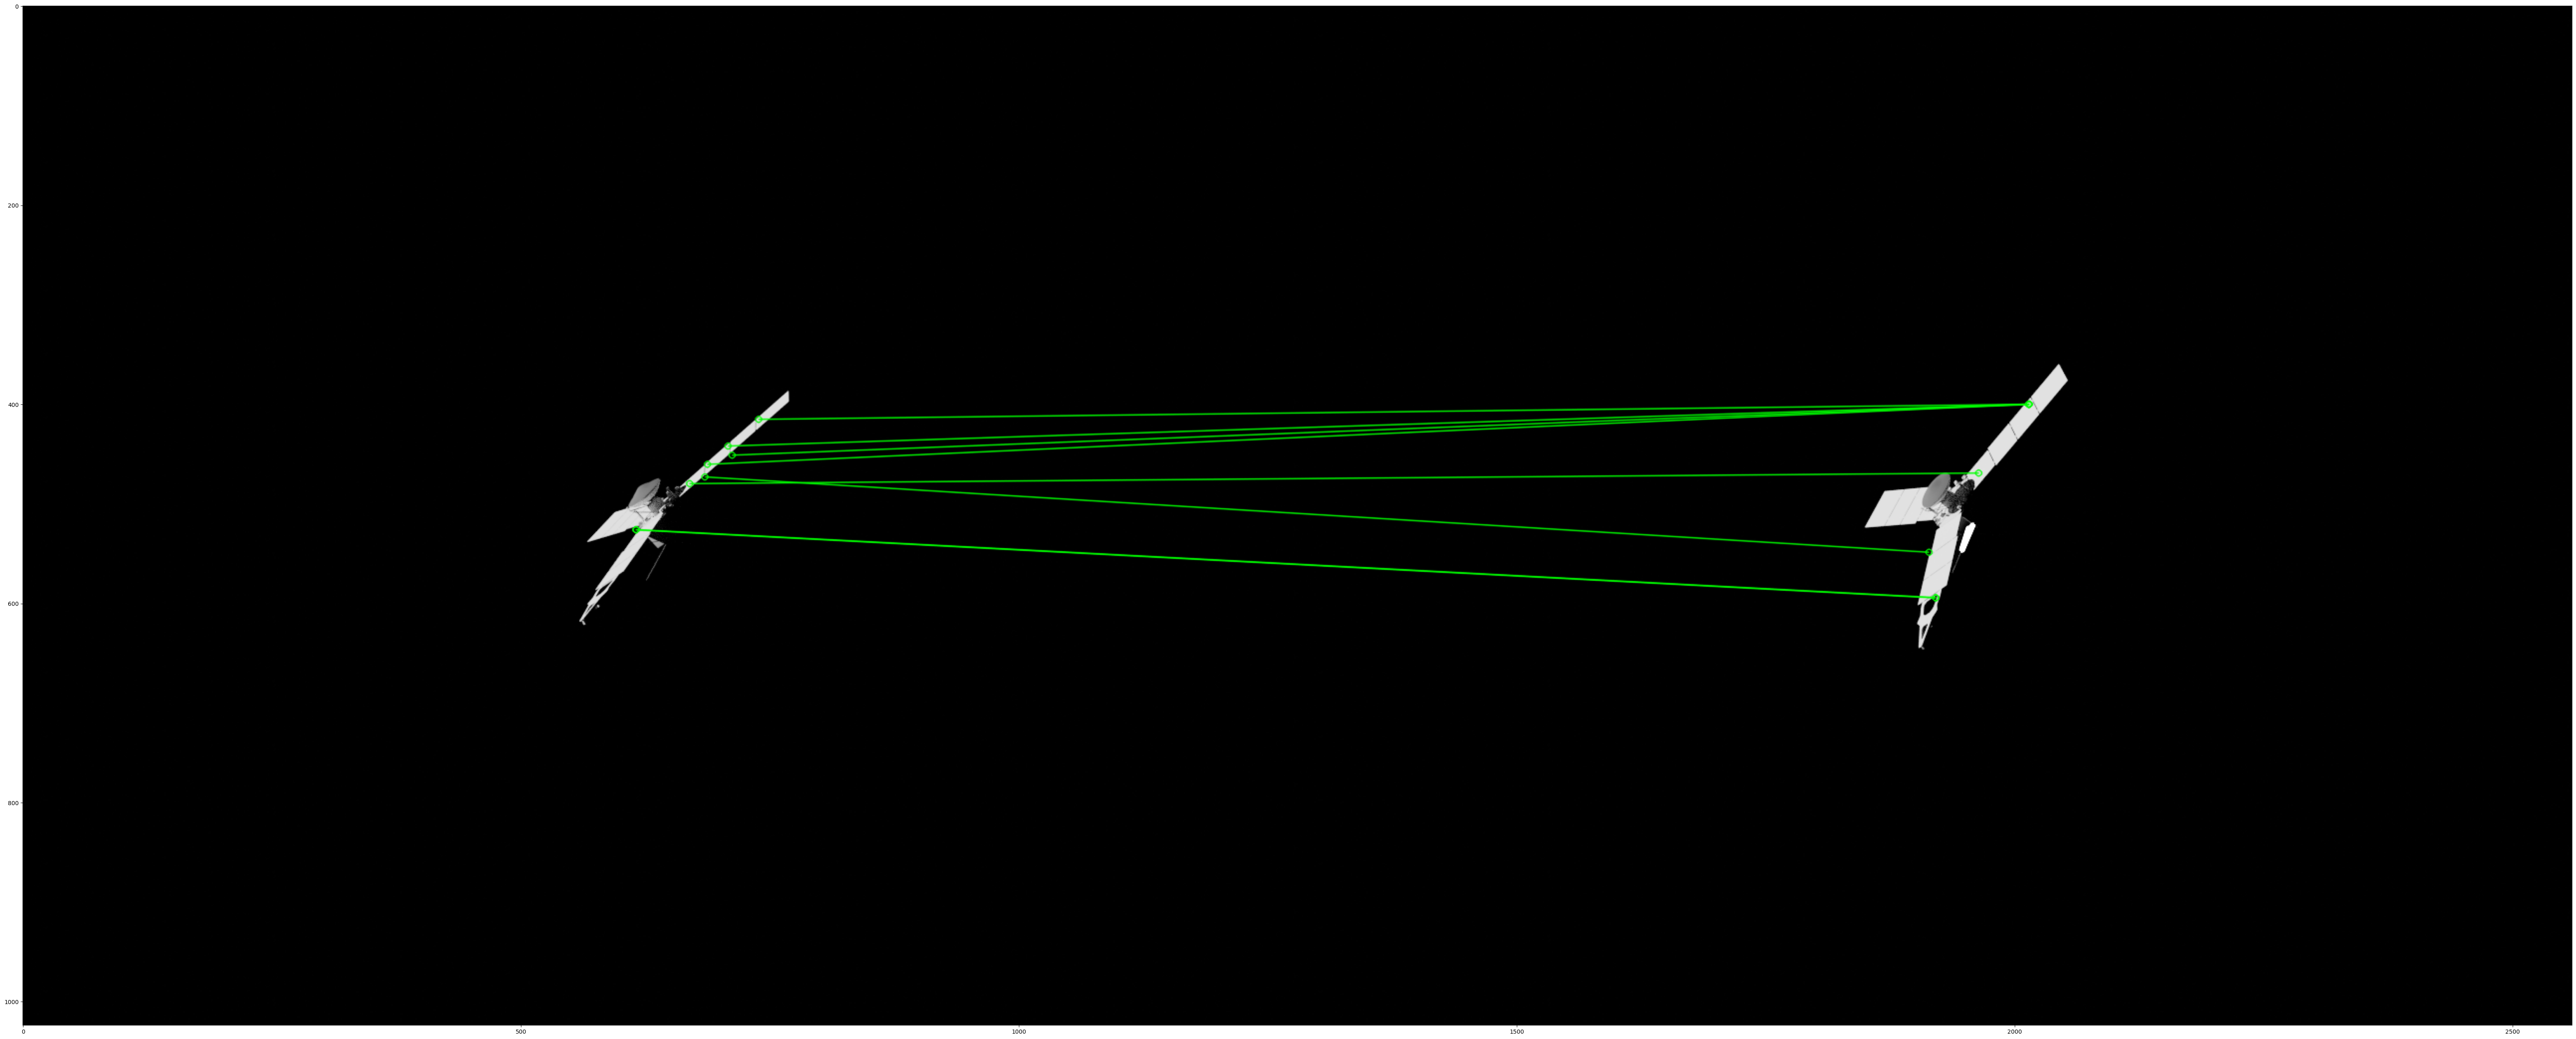

In [130]:
plt.figure(figsize=(80,80))
plt.imshow(imgMatch, 'gray')
plt.show()

In [1]:
# img_rgb = cv.cvtColor(cv.imread(img1path), cv.COLOR_BGR2RGB)
# cv.imshow('Image', img_rgb)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [33]:
def calculate_pose(homography_matrix):
    # Extract rotation and translation from homography matrix
    rot_matrix = np.zeros((3, 3))
    rot_matrix[:, :2] = homography_matrix[:, :2]
    rot_matrix[:, 2] = np.cross(rot_matrix[:, 0], rot_matrix[:, 1])
    translation = homography_matrix[:, 2] / np.linalg.norm(homography_matrix[:, :2])

    # Convert rotation matrix to quaternion
    trace = np.trace(rot_matrix)
    if trace > 0:
        s = 0.5 / np.sqrt(trace + 1.0)
        w = 0.25 / s
        x = (rot_matrix[2, 1] - rot_matrix[1, 2]) * s
        y = (rot_matrix[0, 2] - rot_matrix[2, 0]) * s
        z = (rot_matrix[1, 0] - rot_matrix[0, 1]) * s
    else:
        if rot_matrix[0, 0] > rot_matrix[1, 1] and rot_matrix[0, 0] > rot_matrix[2, 2]:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[0, 0] - rot_matrix[1, 1] - rot_matrix[2, 2])
            w = (rot_matrix[2, 1] - rot_matrix[1, 2]) / s
            x = 0.25 * s
            y = (rot_matrix[0, 1] + rot_matrix[1, 0]) / s
            z = (rot_matrix[0, 2] + rot_matrix[2, 0]) / s
        elif rot_matrix[1, 1] > rot_matrix[2, 2]:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[1, 1] - rot_matrix[0, 0] - rot_matrix[2, 2])
            w = (rot_matrix[0, 2] - rot_matrix[2, 0]) / s
            x = (rot_matrix[0, 1] + rot_matrix[1, 0]) / s
            y = 0.25 * s
            z = (rot_matrix[1, 2] + rot_matrix[2, 1]) / s
        else:
            s = 2.0 * np.sqrt(1.0 + rot_matrix[2, 2] - rot_matrix[0, 0] - rot_matrix[1, 1])
            w = (rot_matrix[1, 0] - rot_matrix[0, 1]) / s
            x = (rot_matrix[0, 2] + rot_matrix[2, 0]) / s
            y = (rot_matrix[1, 2] + rot_matrix[2, 1]) / s
            z = 0.25 * s

    return translation, [x, y, z, w]


In [36]:
translation, quat = calculate_pose(M)

In [37]:
translation

array([620.71499515, 508.70476913,   0.92980055])

In [38]:
quat

[-0.00029664116316386924,
 -0.00031669406374587117,
 0.719521014529947,
 0.049691004139257325]

In [50]:
def move_image(image_path, pose):
    # Read the image
    image = cv.imread(image_path)
    
    # Extract translation and rotation from the pose
    translation = pose[:3]
    quaternion = pose[3:]
    
    # Convert quaternion to rotation matrix
    rotation = Rotation.from_quat(quaternion).as_matrix()
    
    # Apply translation
    translation_matrix = np.eye(4)
    translation_matrix[:3, 3] = translation
    # Apply rotation
    transformation_matrix = np.eye(4)
    transformation_matrix[:3, :3] = rotation
    
    # Apply transformation to image
    rows, cols, _ = image.shape
    new_image = cv.warpPerspective(image, transformation_matrix[:3], (cols, rows))
    
    return new_image

In [54]:
# Move the image
pose = [7.64022827,-46.98920059,-42.21747971,0.98997474,-0.0941886,-0.07856753,0.07003857]
# new_image = move_image(img1path, pose)

# # Show the original and moved image
# cv.imshow('Original Image', cv.imread(img1path))
# cv.imshow('Moved Image', new_image)
# cv.waitKey(0)
# cv.destroyAllWindows()

In [113]:
image = cv.imread(img1path)
translation = np.float32(pose[:3])
quaternion = np.float32(pose[3:])
rotation = Rotation.from_quat(quaternion).as_matrix().astype(np.float32)

In [114]:
quaternion
print(type(quaternion))

<class 'numpy.ndarray'>


In [85]:
def quaternion_to_rotation_matrix(q):
    # Extract quaternion components
    qw, qx, qy, qz = q
    # Compute rotation matrix
    R = np.array([[1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
                  [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
                  [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]])
    return R

In [88]:
R = quaternion_to_rotation_matrix(quaternion)
transformation_matrix = np.identity(4)
transformation_matrix[:3, :3] = R
transformation_matrix[:3, 3] = translation

In [115]:
rotation.dtype

dtype('float32')

In [117]:
cv.perspectiveTransform(

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:2757: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 2 && M0.cols == 3 in function 'warpAffine'


In [97]:
transformation_matrix

array([[  0.97784348,  -0.1238725 ,  -0.16875341,   7.64022827],
       [  0.15347316,   0.97244621,   0.17548315, -46.98920059],
       [  0.14236607,  -0.19749418,   0.9699113 , -42.21747971],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

In [93]:
# Normalize transformation matrix
transformation_matrix = transformation_matrix / transformation_matrix[3, 3]

# Extract rotation and translation components
rotation_matrix = transformation_matrix[0:3, 0:3]
translation_vector = transformation_matrix[0:3, 3]

projection_matrix = np.hstack([rotation_matrix, translation_vector.reshape(3, 1)])

In [96]:
transformed_image = cv.warpPerspective(image, projection_matrix, (image.shape[1], image.shape[0]))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [91]:
transformed_image = cv.warpPerspective(image, transformation_matrix, (image.shape[1], image.shape[0]))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [65]:
# Combine translation and rotation into transformation matrix
transformation_matrix = np.eye(4)
transformation_matrix[:3, :3] = rotation
transformation_matrix[:3, 3] = translation

In [67]:
rows, cols, _ = image.shape

In [69]:
new_image = cv.warpPerspective(image, transformation_matrix[:3], (cols, rows))

error: OpenCV(4.9.0) /home/conda/feedstock_root/build_artifacts/libopencv_1704864625327/work/modules/imgproc/src/imgwarp.cpp:3323: error: (-215:Assertion failed) (M0.type() == CV_32F || M0.type() == CV_64F) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'
